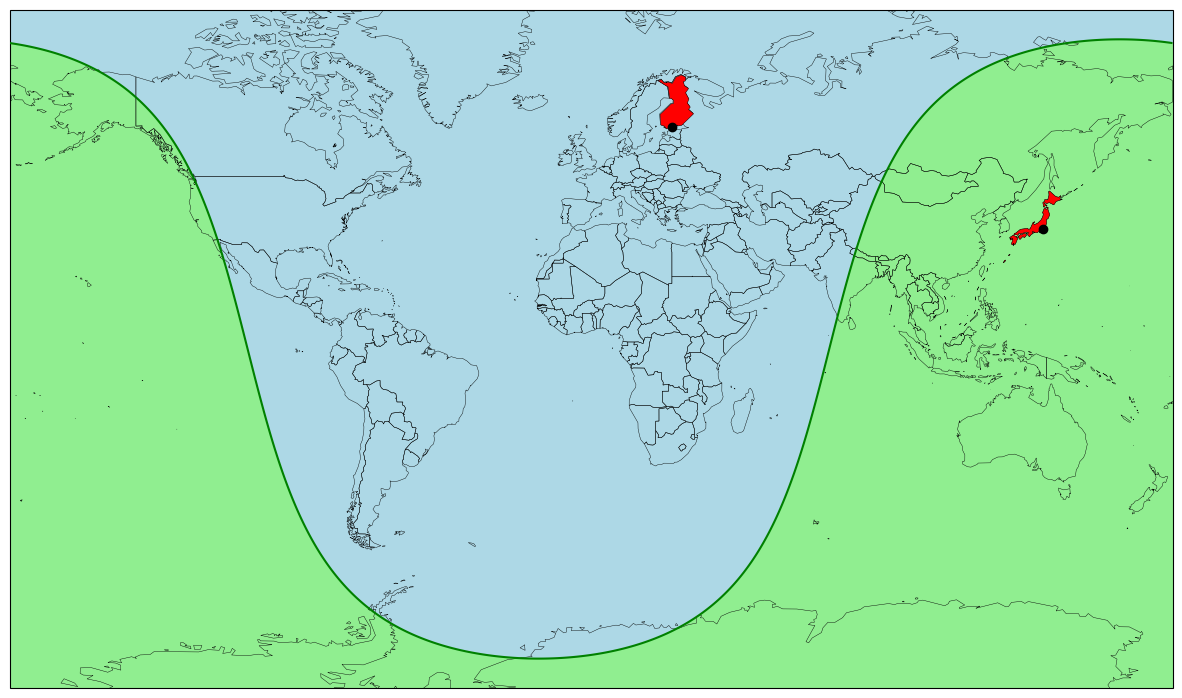

In [1]:
# 球面两点的球面中垂线

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from geopy.distance import geodesic

# 读取地图数据
world = gpd.read_file('./worldmap4/world.json')

# 设置投影
world = world.to_crs(ccrs.PlateCarree())

# 选取目标点所属国家
c1 = world[world['name'] == '芬兰']
c2 = world[world['name'] == '日本']

# 创建绘图对象
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Miller()})

# 绘制世界地图
world.plot(ax=ax, color='none', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree(), zorder=1)

# 将目标点所属国家填充为红色
c1.plot(ax=ax, color='red', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree(), zorder=2)
c2.plot(ax=ax, color='red', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree(), zorder=2)

# 设置两个目标点
lat1, lon1 = 60.17104926742669, 24.93805711554702
lat2, lon2 = 35.680880043438144, 139.77022963207594
# 生成经纬度网格
lats = np.linspace(-90, 90, 300)
lons = np.linspace(-180, 180, 600)
lon_grid, lat_grid = np.meshgrid(lons, lats)
distance_diff = np.zeros(lon_grid.shape)

# 计算每个网格点到目标点的球面距离
for i in range(lon_grid.shape[0]):
    for j in range(lon_grid.shape[1]):
        point = (lat_grid[i, j], lon_grid[i, j])
        d1 = geodesic(point, (lat1, lon1)).kilometers
        d2 = geodesic(point, (lat2, lon2)).kilometers
        distance_diff[i, j] = d1 - d2

# 绘制填充等高线，等价于填充分界线两侧颜色
contourf = ax.contourf(lon_grid, lat_grid, distance_diff, levels=[-1e10, 0, 1e10], colors=['lightblue', 'lightgreen'], transform=ccrs.PlateCarree(), zorder=0)

# 绘制等高线，等价于绘制平分线
contour = ax.contour(lon_grid, lat_grid, distance_diff, levels=[0], colors='green', transform=ccrs.PlateCarree(), zorder=3)

# 绘制目标点
ax.scatter([lon1, lon2], [lat1, lat2], color='black', marker='o', transform=ccrs.PlateCarree(), zorder=4)

# 设置横纵坐标刻度不可见
ax.tick_params(axis='both', which='both', length=0, labelsize=0)

# 设置地图显示范围
ax.set_extent([180, -180, -80, 80], crs=ccrs.PlateCarree())

# 保存图像并显示
# plt.savefig('output6.png', dpi=300, bbox_inches='tight')
plt.show()


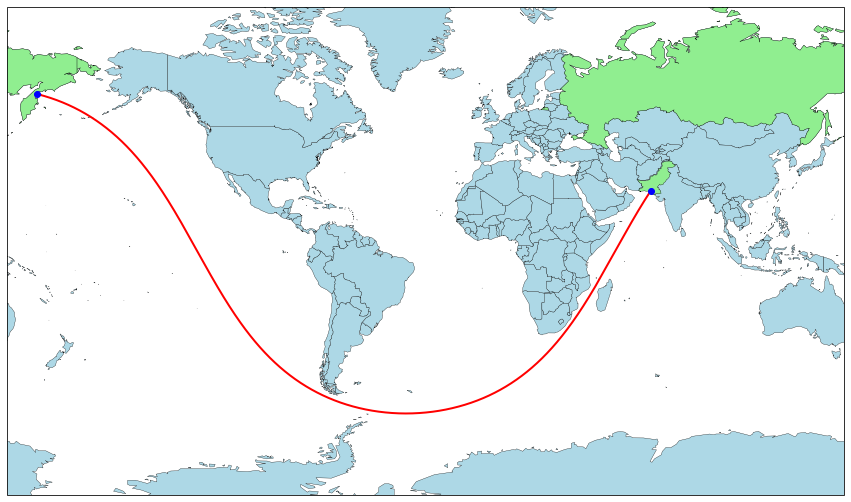

In [8]:
#球面两点的较长大地线

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pyproj import Geod

# 读取世界地图数据
world = gpd.read_file('world.zh.json')
world = world.to_crs(ccrs.PlateCarree())

# 提取俄罗斯和巴基斯坦的数据
c1 = world[world['name'] == '俄罗斯']
c2 = world[world['name'] == '巴基斯坦']

# prepare points
# P1
lat1, lon1 = 59.18232447782983, 162.90673502275226
# P1's antipode
lat1a = -lat1
lon1a = lon1 - 180
# p2
lat2, lon2 = 25.174689841781433, 66.75388912356865
# P2's antipode
lat2a = -lat2
lon2a = lon2 - 180


# 创建图形和投影
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Miller(central_longitude=-30)})
world.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())
c1.plot(ax=ax, color='lightgreen', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())
c2.plot(ax=ax, color='lightgreen', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())

# 使用 pyproj 的 Geod 计算大圆弧线
geod = Geod(ellps="WGS84")

# Geodetic lines: P2-P1_antipode
num_points = 200
point1 = geod.npts(lon2, lat2, lon1a, lat1a, num_points)
# Geodetic lines: P1_antipode-P2_antipode
point2 = geod.npts(lon1a, lat1a, lon2a, lat2a, num_points)
# Geodetic lines: P2_antipode-P1
point3 = geod.npts(lon2a, lat2a, lon1, lat1, num_points)
points = point1 + point2 + point3

# 提取较长的一段路径
lons, lats = zip(*points)
# 绘制较长的大圆弧线
ax.plot(lons, lats, color='red', linewidth=2, transform=ccrs.Geodetic())

# 在地图上标记特定的经纬度点
ax.scatter([lon1, lon2], [lat1, lat2], color='b', marker='o', zorder=5, transform=ccrs.PlateCarree())

# 设置图形的外观和保存图像
ax.tick_params(axis='both', which='both', length=0, labelsize=0)
ax.set_extent([180, -180, -80, 80], crs=ccrs.PlateCarree())
# plt.savefig('outputN.png', dpi=300, bbox_inches='tight')
plt.show()


In [7]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt

# 读取美国各州的GeoJSON文件
world = gpd.read_file('./province/ne_10m_admin_1_states_provinces.shp')
us = world[world['admin'] == 'United States of America']
us = us.to_crs(ccrs.PlateCarree())


# 创建图并添加节点和边
G = nx.Graph()

for index, state in us.iterrows():
    state_name = state['name']
    G.add_node(state_name)
    for index2, state2 in us.iterrows():
        if state_name != state2['name'] and state['geometry'].touches(state2['geometry']):
            G.add_edge(state_name, state2['name'])

# 标记直接与海洋接壤的州（假设这些州已经预先定义）
ocean_bordering_states = [
    'California', 'Oregon', 'Washington', 'Texas', 'Louisiana', 'Mississippi', 
    'Alabama', 'Florida', 'Georgia', 'South Carolina', 'North Carolina', 'Virginia',
    'Maryland', 'Delaware', 'New Jersey', 'New York', 'Connecticut', 'Rhode Island',
    'Massachusetts', 'New Hampshire', 'Maine', 'Hawaii'
]

# 使用BFS计算每个州到达海洋的最小间隔州数
min_steps_to_ocean = {state: float('inf') for state in G.nodes}
print(min_steps_to_ocean)

for ocean_state in ocean_bordering_states:
    for state in G.nodes:
        if state is not ocean_state:
            try:
                steps = nx.shortest_path_length(G, source=state, target=ocean_state)
                if steps < min_steps_to_ocean[state]:
                    min_steps_to_ocean[state] = steps
            except nx.NetworkXNoPath:
                continue

# 打印结果
for state, steps in min_steps_to_ocean.items():
    print(f'{state}: {steps} steps to the nearest ocean')




{'Washington': inf, 'Idaho': inf, 'Oregon': inf, 'Montana': inf, 'Utah': inf, 'Wyoming': inf, 'Nevada': inf, 'North Dakota': inf, 'South Dakota': inf, 'Minnesota': inf, 'Michigan': inf, 'Iowa': inf, 'Wisconsin': inf, 'Ohio': inf, 'Illinois': inf, 'Indiana': inf, 'Pennsylvania': inf, 'Kentucky': inf, 'West Virginia': inf, 'New York': inf, 'Maryland': inf, 'Delaware': inf, 'New Jersey': inf, 'Vermont': inf, 'Connecticut': inf, 'Massachusetts': inf, 'New Hampshire': inf, 'Maine': inf, 'Arizona': inf, 'California': inf, 'New Mexico': inf, 'Colorado': inf, 'Texas': inf, 'Oklahoma': inf, 'Louisiana': inf, 'Arkansas': inf, 'Alaska': inf, 'Mississippi': inf, 'Alabama': inf, 'Tennessee': inf, 'Florida': inf, 'Georgia': inf, 'South Carolina': inf, 'North Carolina': inf, 'Virginia': inf, 'District of Columbia': inf, 'Rhode Island': inf, 'Hawaii': inf, 'Nebraska': inf, 'Kansas': inf, 'Missouri': inf}
Washington: 0 steps to the nearest ocean
Idaho: 1 steps to the nearest ocean
Oregon: 0 steps to th

In [26]:
import geopandas as gpd
import pandas as pd

province = gpd.read_file('./chinamap/province/test.json')
province.head(10)
province.to_csv('china_city2.csv', index=False, encoding='utf-8-sig')
# c1 = rivers[rivers['name_zh'] == '多瑙河']
# c1

(0.993248, 0.906157, 0.143936, 1.0)
['Washington', 'Oregon', 'New York', 'Maryland', 'Delaware', 'New Jersey', 'Connecticut', 'Massachusetts', 'New Hampshire', 'Maine', 'California', 'Texas', 'Louisiana', 'Alaska', 'Mississippi', 'Alabama', 'Florida', 'Georgia', 'South Carolina', 'North Carolina', 'Virginia', 'Rhode Island', 'Hawaii']
(0.360741, 0.785964, 0.387814, 1.0)
['Idaho', 'Nevada', 'Pennsylvania', 'Kentucky', 'West Virginia', 'Vermont', 'Arizona', 'New Mexico', 'Oklahoma', 'Arkansas', 'Tennessee', 'District of Columbia']
(0.128729, 0.563265, 0.551229, 1.0)
['Montana', 'Utah', 'Wyoming', 'Ohio', 'Illinois', 'Indiana', 'Colorado', 'Kansas', 'Missouri']
(0.231674, 0.318106, 0.544834, 1.0)
['North Dakota', 'South Dakota', 'Michigan', 'Iowa', 'Wisconsin', 'Nebraska']
(0.267004, 0.004874, 0.329415, 1.0)
['Minnesota']


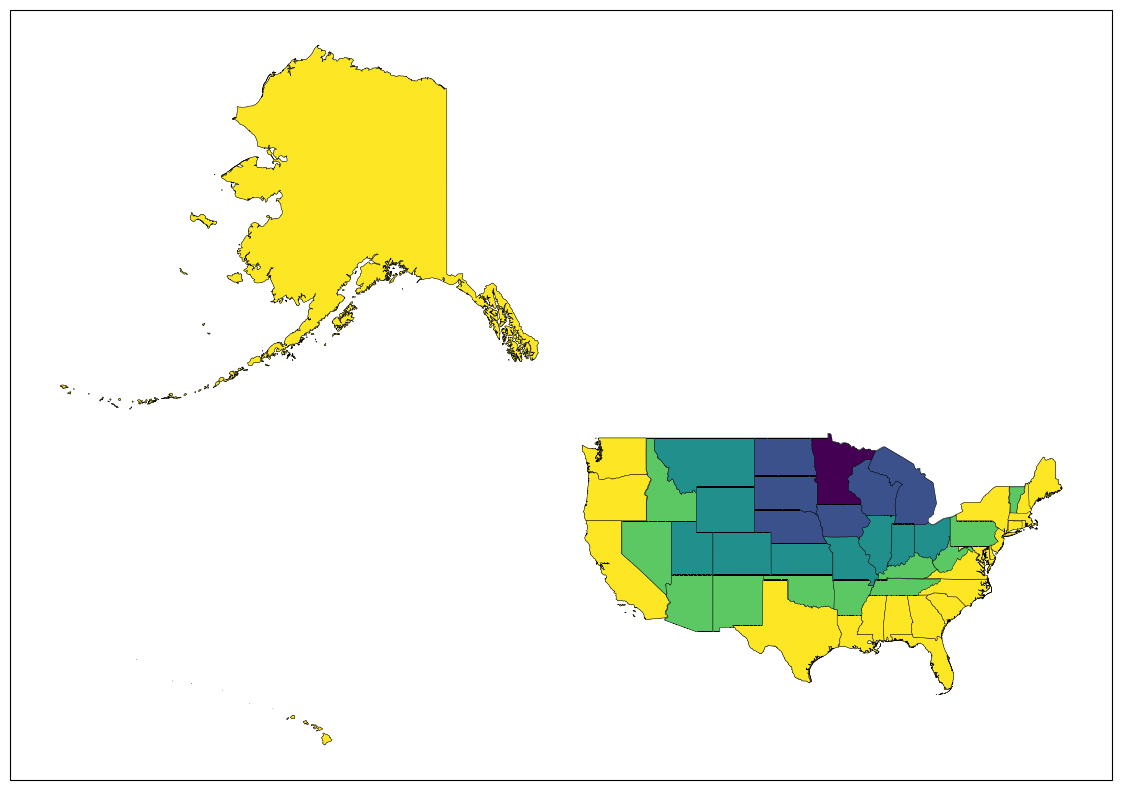

In [21]:
# 行政区分析

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

def findStepMax(min_steps_to_ocean):
    stepMax = 0
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps > stepMax:
            stepMax = steps
    return stepMax


world = gpd.read_file('./province/ne_10m_admin_1_states_provinces.shp')
us = world[world['admin'] == 'United States of America']
us = us.to_crs(ccrs.PlateCarree())

fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Mercator(central_longitude=150)})
us.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())

G = nx.Graph()

for index, state in us.iterrows():
    state_name = state['name']
    G.add_node(state_name)
    for index2, state2 in us.iterrows():
        if state_name != state2['name'] and state['geometry'].touches(state2['geometry']):
            G.add_edge(state_name, state2['name'])


ocean_bordering_states = [
    'California', 'Oregon', 'Washington', 'Texas', 'Louisiana', 'Mississippi', 
    'Alabama', 'Florida', 'Georgia', 'South Carolina', 'North Carolina', 'Virginia',
    'Maryland', 'Delaware', 'New Jersey', 'New York', 'Connecticut', 'Rhode Island',
    'Massachusetts', 'New Hampshire', 'Maine', 'Hawaii', 'Alaska'
]

min_steps_to_ocean = {state: float('inf') for state in G.nodes}

for ocean_state in ocean_bordering_states:
    for state in G.nodes:
        if state is not ocean_state:
            try:
                steps = nx.shortest_path_length(G, source=state, target=ocean_state)
                if steps < min_steps_to_ocean[state]:
                    min_steps_to_ocean[state] = steps
            except nx.NetworkXNoPath:
                continue

colorMap = {
    0: "red",
    1: "yellow",
    2: "blue",
    3: "green",
    4: "purple"
}

stepMax = findStepMax(min_steps_to_ocean)
norm = Normalize(vmin=0, vmax=stepMax)
scalarMap = cm.ScalarMappable(norm=norm, cmap='viridis_r')

for i in range(0, stepMax+1):
    stateList = []
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps == i:
            stateList.append(state)
    # color = colorMap.get(i, '')
    color = scalarMap.to_rgba(i)
    print(color)
    print(stateList)
    for state in stateList:
        state_data = us[us['name'] == state]
        if not state_data.empty:
            state_data.plot(ax=ax, color=color, edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())
 


ax.tick_params(axis='both', which='both', length=0, labelsize=0)

# ax.set_extent([-25, 40, 33, 68], crs=ccrs.PlateCarree())
# plt.savefig('output1.png', dpi=300, bbox_inches='tight')
plt.show()


(0.993248, 0.906157, 0.143936, 1.0)
['汕尾市', '漳州市', '揭阳市', '潮州市', '舟山市', '葫芦岛市', '秦皇岛市', '锦州市', '深圳市', '惠州市', '香港特别行政区', '东莞市', '泉州市', '福州市', '大连市', '丹东市', '营口市', '嘉兴市', '滨州市', '珠海市', '澳门特别行政区', '中山市', '江门市', '厦门市', '莆田市', '日照市', '潍坊市', '连云港市', '盘锦市', '唐山市', '天津市', '台州市', '盐城市', '南通市', '汕头市', '威海市', '烟台市', '宁波市', '阳江市', '茂名市', '广州市', '青岛市', '三亚市', '陵水黎族自治县', '乐东黎族自治县', '台湾省', '万宁市', '昌江黎族自治县', '东方市', '东营市', '沧州市', '儋州市', '临高县', '澄迈县', '海口市', '琼海市', '文昌市', '上海市', '宁德市', '温州市', '防城港市', '钦州市', '北海市', '三沙市', '湛江市']
(0.360741, 0.785964, 0.387814, 1.0)
['梅州市', '河源市', '龙岩市', '朝阳市', '承德市', '阜新市', '杭州市', '湖州市', '三明市', '南平市', '鞍山市', '梧州市', '清远市', '境界线', '徐州市', '保定市', '衡水市', '金华市', '丽水市', '济南市', '德州市', '淄博市', '临沂市', '崇左市', '南宁市', '沈阳市', '辽阳市', '韶关市', '绍兴市', '淮安市', '扬州市', '泰州市', '云浮市', '宿迁市', '佛山市', '本溪市', '保亭黎族苗族自治县', '贵港市', '玉林市', '琼中黎族苗族自治县', '五指山市', '白沙黎族自治县', '通化市', '屯昌县', '定安县', '苏州市', '北京市', '廊坊市']
(0.128729, 0.563265, 0.551229, 1.0)
['赣州市', '忻州市', '赤峰市', '通辽市', '菏泽市', '聊城市', '济宁市', '泰安市', '

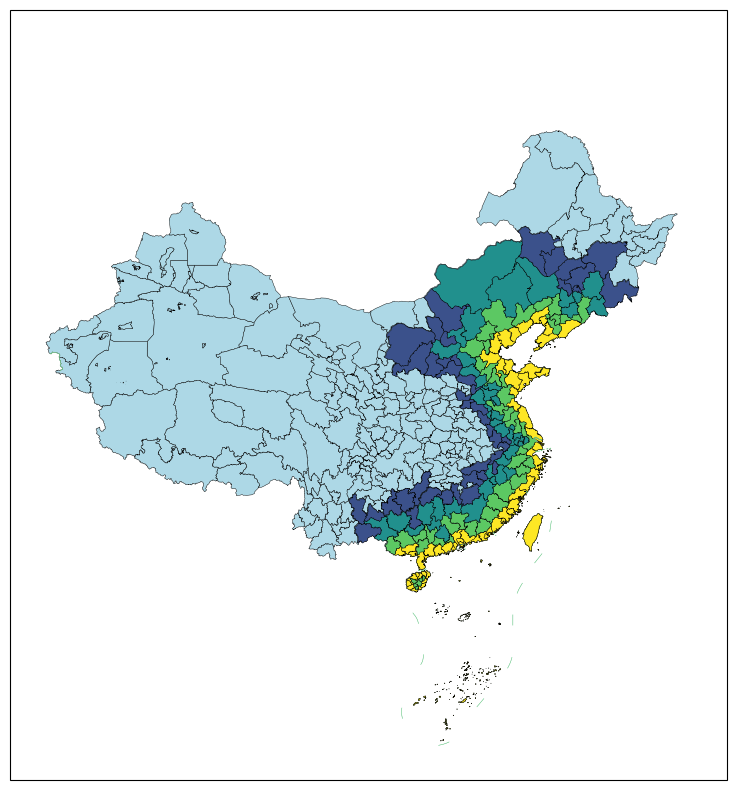

In [11]:
# 勘误：阳西县-阳江市，海丰县-汕尾市，揭阳县-揭阳市，市辖区(南通市)-
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

def findStepMax(min_steps_to_ocean):
    stepMax = 0
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps > stepMax:
            stepMax = steps
    return stepMax


# 读取地图数据
# world = gpd.read_file('./chinamap/china_standard_shp/中国地州界.shp')
world = gpd.read_file('./shp2json/chinacity.geojson')
# china = gpd.read_file('./chinamap/geo_china.json')
# world = gpd.read_file('output.geojson')
world = world.to_crs(ccrs.PlateCarree())
# china = china.to_crs(ccrs.PlateCarree())


G = nx.Graph()
for index, state in world.iterrows():
    state_name = state['name']
    G.add_node(state_name)
    for index2, state2 in world.iterrows():
        if state_name != state2['name'] and state['geometry'].touches(state2['geometry']):
            G.add_edge(state_name, state2['name'])

# china_ocean_city = ['振兴区','东港市','庄河市','长海县','普兰店区','金州区','中山区','西岗区','沙河口区','甘井子区','旅顺口区','瓦房店市','盖州市','鲅鱼圈区','西市区','大洼区',
#                     '兴隆台区','凌海市','太和区','连山区','龙岗区','兴城市','绥中县','山海关区','海港区','北戴河区','抚宁区','昌黎县','乐亭县','曹妃甸区',
#                     '滦南区','丰南区','滨海新区','黄骅市','无棣县','沾化区','河口区','利津县','垦利区','东营区','广饶县','寿光县','寒亭区','昌邑市','莱州市',
#                     '招远市','龙口市','蓬莱区','福山区','芝罘区','莱山区','牟平区','环翠区','荣成市','文登区','乳山市','海阳市','莱阳市','即墨区','崂山区',
#                     '李沧区','城阳区','胶州市','黄岛区','东港区','岚山区','赣榆区','连云区','灌云县','响水县','滨海县','射阳县','亭湖区','大丰区','东台市',
#                     '海安市','如东县','通州区','海门区','启东市','崇敏区','太仓市','宝山区','浦东新区','奉贤区','金山区','平湖市','海盐县','余姚市','慈溪市',
#                     '镇海区','北仓去','定海区','普陀区','岱山县','嵊泗县','鄞州区','奉化区','宁海县','象山县','三门县','临海市','椒江区','路桥区','温岭市','玉环市',
#                     '乐清市','洞头区','龙湾区','瑞安市','平阳县','龙港市','苍南县']

china_ocean_city = ['丹东市','大连市','营口市','盘锦市','锦州市','葫芦岛市','秦皇岛市','唐山市','天津市','沧州市','滨州市','东营市','潍坊市','烟台市',
                    '威海市','青岛市','日照市','连云港市','盐城市','南通市','上海市','嘉兴市','宁波市','舟山市','台州市','温州市','宁德市','福州市',
                    '莆田市','泉州市','厦门市','漳州市','潮州市','汕头市','揭阳市','汕尾市','惠州市','深圳市','东莞市','广州市','中山市','珠海市',
                    '江门市','阳江市','茂名市','湛江市','北海市','钦州市','防城港市','台湾省','香港特别行政区','澳门特别行政区','海口市','澄迈县',
                    '临高县','儋州市','昌江黎族自治县','东方市','乐东黎族自治县','三亚市','陵水黎族自治县','万宁市','琼海市','文昌市','三沙市']


min_steps_to_ocean = {state: float('inf') for state in G.nodes}

for ocean_state in china_ocean_city:
    for state in G.nodes:
        if state is not ocean_state:
            try:
                steps = nx.shortest_path_length(G, source=state, target=ocean_state)
                if steps < min_steps_to_ocean[state]:
                    min_steps_to_ocean[state] = steps
            except nx.NetworkXNoPath:
                continue


colorMap = {
    0: "red",
    1: "yellow",
    2: "blue",
    3: "green",
    4: "purple"
}

# 创建绘图对象
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Mercator(central_longitude=150)})
world.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())


for city in china_ocean_city:
    city_data = world[world['name'] == city]
    if not city_data.empty:
        city_data.plot(ax=ax, color='lightgreen', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())


stepMax = findStepMax(min_steps_to_ocean)
norm = Normalize(vmin=0, vmax=4)
scalarMap = cm.ScalarMappable(norm=norm, cmap='viridis_r')

for i in range(0, 4):
    stateList = []
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps == i:
            stateList.append(state)
    # color = colorMap.get(i, '')
    color = scalarMap.to_rgba(i)
    print(color)
    print(stateList)
    for state in stateList:
        state_data = world[world['name'] == state]
        if not state_data.empty:
            state_data.plot(ax=ax, color=color, edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())

# china.plot(ax=ax, color='None', edgecolor='red', linewidth=0.8, transform=ccrs.PlateCarree())



# 设置地图显示范围
ax.set_extent([70, 140, 0, 60], crs=ccrs.PlateCarree())

# 保存图像并显示
plt.savefig('output1.png', dpi=400, bbox_inches='tight')
plt.show()


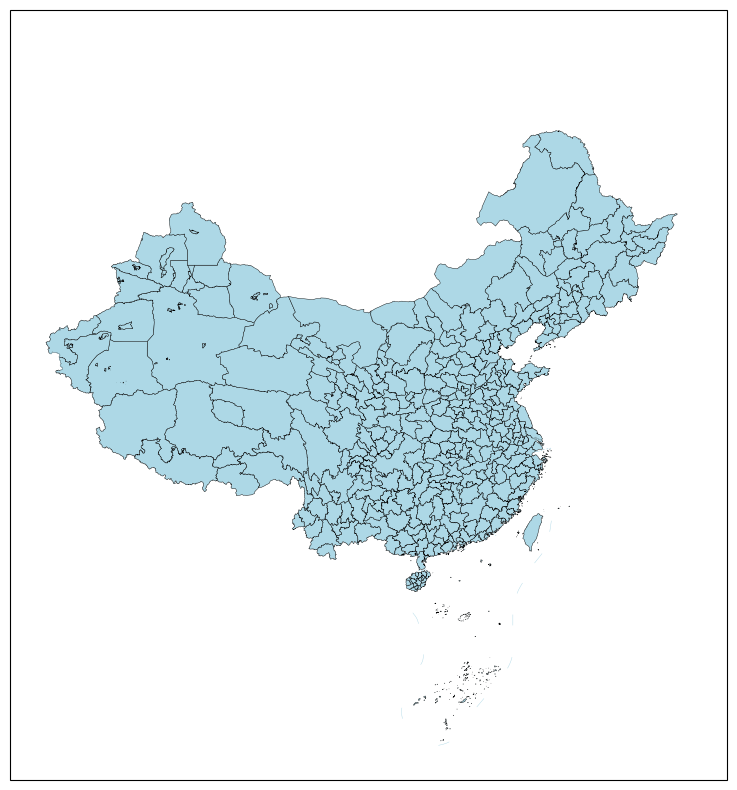

In [1]:

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize

# 读取地图数据
# world = gpd.read_file('./chinamap/province/test.json')
# world = gpd.read_file('output.geojson')
world = gpd.read_file('./shp2json/chinacity.geojson')
world = world.to_crs(ccrs.PlateCarree())

fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Mercator(central_longitude=150)})
world.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())


# 设置地图显示范围
ax.set_extent([70, 140, 0, 60], crs=ccrs.PlateCarree())

plt.show()


In [2]:

import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import networkx as nx
import math
from matplotlib import cm
from matplotlib.colors import Normalize

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

def findStepMax(min_steps_to_ocean):
    stepMax = 0
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps > stepMax:
            stepMax = steps
    return stepMax


# 读取地图数据
world = gpd.read_file('./chinamap/province/test.json')
world = world.to_crs(ccrs.PlateCarree())


G = nx.Graph()
for index, state in world.iterrows():
    state_name = state['name']
    G.add_node(state_name)
    for index2, state2 in world.iterrows():
        if state_name != state2['name'] and state['geometry'].touches(state2['geometry']):
            G.add_edge(state_name, state2['name'])


china_ocean_city = ['丹东市','大连市','营口市','盘锦市','锦州市','葫芦岛市','秦皇岛市','唐山市','沧州市','天津市','滨州市','东营市','潍坊市','威海市','烟台市',
                    '青岛市','日照市','连云港市','盐城市','南通市','嘉兴市','杭州市','绍兴市','舟山市','宁波市','台州市','温州市','宁德市','福州市','莆田市',
                    '泉州市','厦门市','漳州市','潮州市','汕头市','揭阳市','汕尾市','惠州市','深圳市','东莞市','广州市','中山市','珠海市','江门市','阳江市',
                    '茂名市','湛江市','北海市','钦州市','防城港市','上海市','香港','澳门','海口市','三亚市','澄迈县','临高县','儋州市','昌江黎族自治县','东方市',
                    '乐东黎族自治县','陵水黎族自治县','万宁市','琼海市','文昌市','台湾省']

min_steps_to_ocean = {state: float('inf') for state in G.nodes}

for ocean_state in china_ocean_city:
    for state in G.nodes:
        if state is not ocean_state:
            try:
                steps = nx.shortest_path_length(G, source=state, target=ocean_state)
                if steps < min_steps_to_ocean[state]:
                    min_steps_to_ocean[state] = steps
            except nx.NetworkXNoPath:
                continue


colorMap = {
    0: "red",
    1: "yellow",
    2: "blue",
    3: "green",
    4: "purple"
}

# 创建绘图对象
fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.Mercator(central_longitude=150)})
world.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())

for city in china_ocean_city:
    city_data = world[world['name'] == city]
    if not city_data.empty:
        city_data.plot(ax=ax, color='lightgreen', edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())


stepMax = findStepMax(min_steps_to_ocean)
norm = Normalize(vmin=0, vmax=4)
scalarMap = cm.ScalarMappable(norm=norm, cmap='viridis_r')

for i in range(0, 4):
    stateList = []
    for state, steps in min_steps_to_ocean.items():
        if math.isinf(steps):
            steps = 1
        if steps == i:
            stateList.append(state)
    # color = colorMap.get(i, '')
    color = scalarMap.to_rgba(i)
    print(color)
    print(stateList)
    for state in stateList:
        state_data = world[world['name'] == state]
        if not state_data.empty:
            state_data.plot(ax=ax, color=color, edgecolor='black', linewidth=0.3, transform=ccrs.PlateCarree())



# 设置地图显示范围
ax.set_extent([70, 140, 10, 60], crs=ccrs.PlateCarree())

# 保存图像并显示
# plt.savefig('output1.png', dpi=400, bbox_inches='tight')
plt.show()


GEOSException: TopologyException: side location conflict at 117.36708899999957 40.172648999999844. This can occur if the input geometry is invalid.